In [1]:
!git clone https://github.com/abhyuditjain/pytorch-models
!mv pytorch-models/* ./
!rm -rf pytorch-models

Cloning into 'pytorch-models'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 171 (delta 108), reused 116 (delta 53), pack-reused 0
Receiving objects: 100% (171/171), 53.73 KiB | 965.00 KiB/s, done.
Resolving deltas: 100% (108/108), done.
mv: cannot move 'pytorch-models/models' to './models': Directory not empty
mv: cannot move 'pytorch-models/utils' to './utils': Directory not empty


In [2]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn
from utils.dataloader import Cifar10DataLoader
from utils.transforms import CustomResnetTransforms
from models.custom_resnet import CustomResNet
from utils.trainer import Trainer
from utils.tester import Tester
from utils.summary import print_summary
from utils.utils import (
    show_misclassified_images,
    show_training_images,
    show_grad_cam,
    show_losses_and_accuracies,
    get_device,
    show_lr_history,
)
from main import train_model, get_lr

/home/carb0n/.pyenv/versions/3.10.12/envs/era-v1-pyenv/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
is_cuda_available, device = get_device()
print_summary(CustomResNet(), device, input_size=(3, 32, 32))

Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
CustomResNet (CustomResNet)              --                        [20, 3, 32, 32]           [20, 10]                  --                        --                        True
├─Sequential (prep_layer)                --                        [20, 3, 32, 32]           [20, 64, 32, 32]          --                        --                        True
│    └─Conv2d (0)                        [3, 3]                    [20, 3, 32, 32]           [20, 64, 32, 32]          1,728                     35,389,440                True
│    └─BatchNorm2d (1)                   --                        [20, 64, 32, 32]          [20, 64, 32, 32]          128                       2,560                     True
│    └─ReLU (2)                          --                        [20, 64, 32, 32]          [20, 64, 32, 32]      

In [4]:
cifar10 = Cifar10DataLoader(CustomResnetTransforms, 512, is_cuda_available)
train_loader = cifar10.get_loader(train=True)
test_loader = cifar10.get_loader(train=False)

Files already downloaded and verified
Files already downloaded and verified


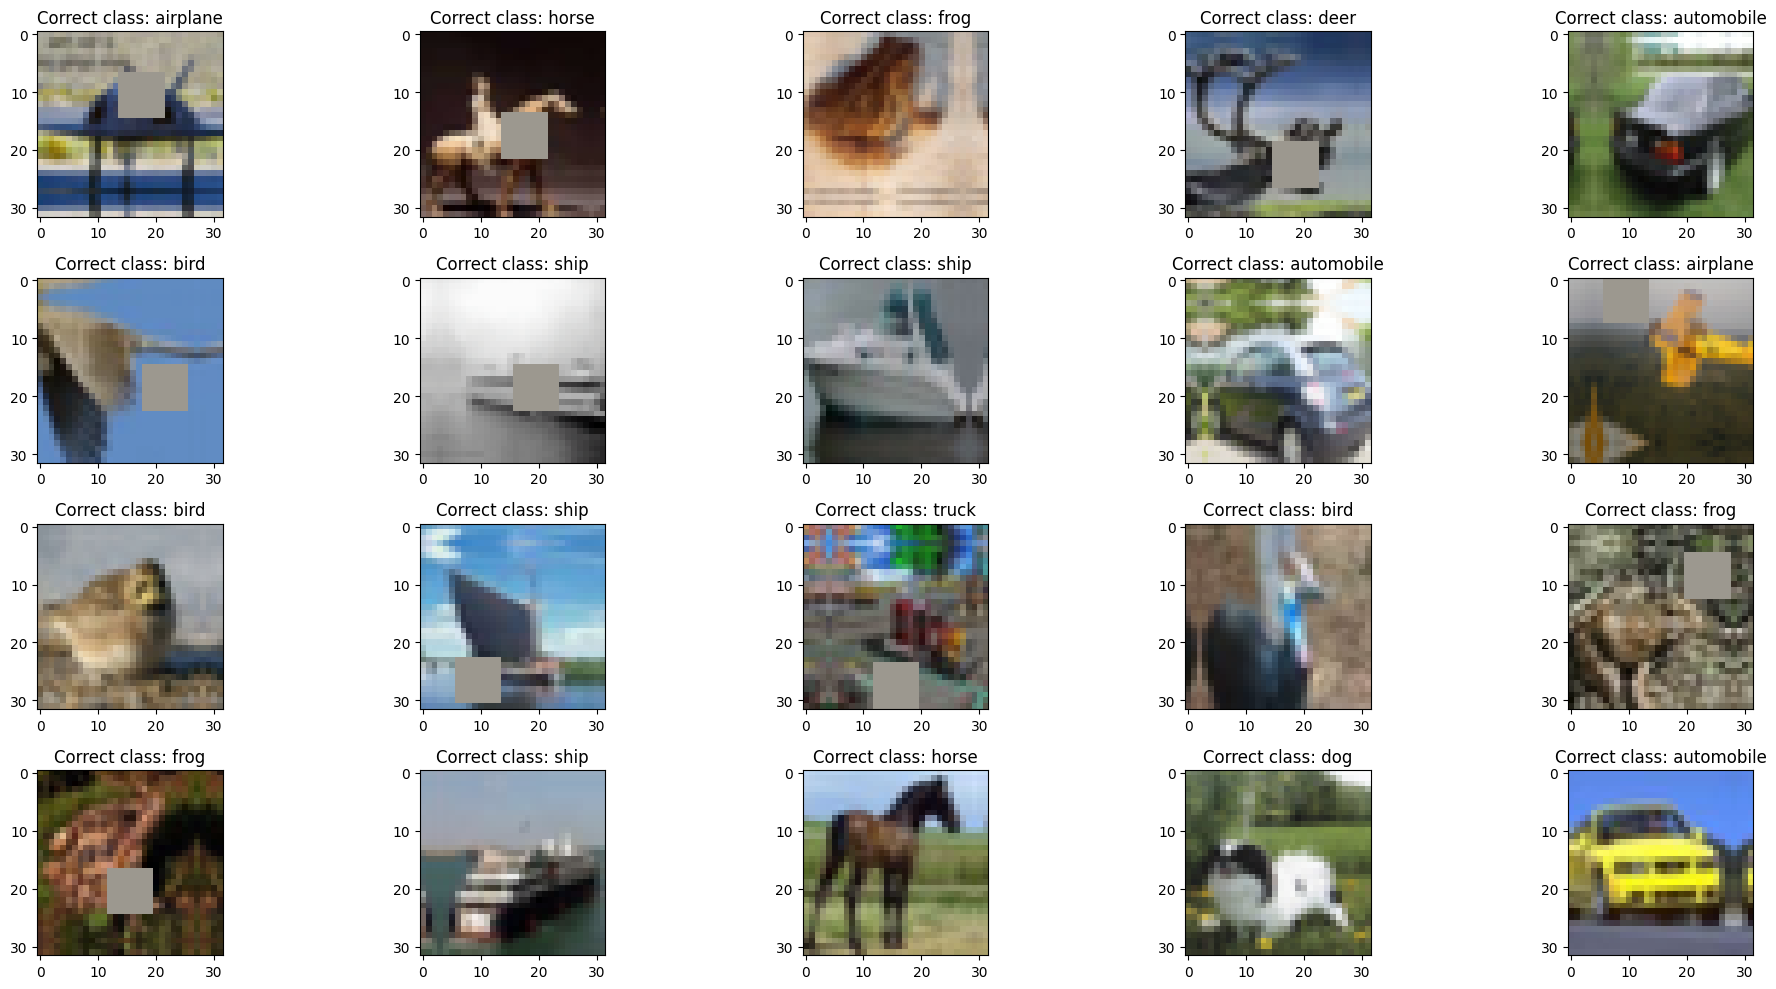

In [5]:
show_training_images(train_loader, 20, cifar10.classes)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.59E-03


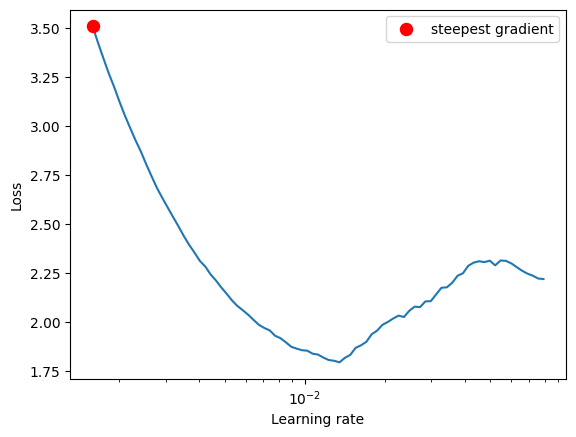

Min Loss = 1.7942351109377381, Max LR = 0.013530477745798068


In [6]:
model = CustomResNet()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)
criterion = nn.CrossEntropyLoss()

# The model parameters are reset after this finishes
min_loss, max_lr = get_lr(
    model,
    train_loader,
    optimizer,
    criterion,
    device,
    end_lr=0.1,
    num_iter=100,
    step_mode="exp",
)

In [7]:
EPOCHS = 24

scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=5 / EPOCHS,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
)

trainer = Trainer(model, train_loader, optimizer, criterion, device)
tester = Tester(model, test_loader, criterion, device)

model, history = train_model(
    trainer, tester, NUM_EPOCHS=EPOCHS, scheduler=scheduler, save_best=False
)

EPOCH = 1 | LR = 0.0028198179694770573 | Loss = 1.01 | Batch = 97 | Accuracy = 52.12: 100%|██████████| 98/98 [00:13<00:00,  7.38it/s] 


Test set: Average loss: 0.0023, Accuracy: 6050/10000 (60.50%)



EPOCH = 2 | LR = 0.0055043311614961345 | Loss = 0.89 | Batch = 97 | Accuracy = 68.77: 100%|██████████| 98/98 [00:12<00:00,  7.59it/s]


Test set: Average loss: 0.0019, Accuracy: 6940/10000 (69.40%)



EPOCH = 3 | LR = 0.00818884435351521 | Loss = 0.65 | Batch = 97 | Accuracy = 73.84: 100%|██████████| 98/98 [00:12<00:00,  7.59it/s]  


Test set: Average loss: 0.0014, Accuracy: 7752/10000 (77.52%)



EPOCH = 4 | LR = 0.010873357545534288 | Loss = 0.75 | Batch = 97 | Accuracy = 74.60: 100%|██████████| 98/98 [00:12<00:00,  7.59it/s]


Test set: Average loss: 0.0018, Accuracy: 7383/10000 (73.83%)



EPOCH = 5 | LR = 0.013523211835648754 | Loss = 0.68 | Batch = 97 | Accuracy = 79.20: 100%|██████████| 98/98 [00:12<00:00,  7.59it/s]


Test set: Average loss: 0.0013, Accuracy: 7874/10000 (78.74%)



EPOCH = 6 | LR = 0.01281115264101594 | Loss = 0.44 | Batch = 97 | Accuracy = 82.40: 100%|██████████| 98/98 [00:12<00:00,  7.60it/s] 


Test set: Average loss: 0.0010, Accuracy: 8310/10000 (83.10%)



EPOCH = 7 | LR = 0.012099093446383123 | Loss = 0.34 | Batch = 97 | Accuracy = 85.98: 100%|██████████| 98/98 [00:12<00:00,  7.59it/s]


Test set: Average loss: 0.0009, Accuracy: 8538/10000 (85.38%)



EPOCH = 8 | LR = 0.011387034251750309 | Loss = 0.34 | Batch = 97 | Accuracy = 87.34: 100%|██████████| 98/98 [00:12<00:00,  7.57it/s]


Test set: Average loss: 0.0008, Accuracy: 8630/10000 (86.30%)



EPOCH = 9 | LR = 0.010674975057117493 | Loss = 0.33 | Batch = 97 | Accuracy = 88.76: 100%|██████████| 98/98 [00:12<00:00,  7.56it/s]


Test set: Average loss: 0.0008, Accuracy: 8637/10000 (86.37%)



EPOCH = 10 | LR = 0.009962915862484677 | Loss = 0.27 | Batch = 97 | Accuracy = 90.08: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]


Test set: Average loss: 0.0008, Accuracy: 8730/10000 (87.30%)



EPOCH = 11 | LR = 0.009250856667851862 | Loss = 0.21 | Batch = 97 | Accuracy = 91.63: 100%|██████████| 98/98 [00:12<00:00,  7.55it/s]


Test set: Average loss: 0.0008, Accuracy: 8748/10000 (87.48%)



EPOCH = 12 | LR = 0.008538797473219048 | Loss = 0.18 | Batch = 97 | Accuracy = 92.15: 100%|██████████| 98/98 [00:12<00:00,  7.59it/s]


Test set: Average loss: 0.0007, Accuracy: 8881/10000 (88.81%)



EPOCH = 13 | LR = 0.007826738278586232 | Loss = 0.22 | Batch = 97 | Accuracy = 92.93: 100%|██████████| 98/98 [00:12<00:00,  7.58it/s]


Test set: Average loss: 0.0007, Accuracy: 8877/10000 (88.77%)



EPOCH = 14 | LR = 0.007114679083953418 | Loss = 0.14 | Batch = 97 | Accuracy = 93.70: 100%|██████████| 98/98 [00:13<00:00,  7.46it/s] 


Test set: Average loss: 0.0006, Accuracy: 9024/10000 (90.24%)



EPOCH = 15 | LR = 0.006402619889320602 | Loss = 0.16 | Batch = 97 | Accuracy = 94.67: 100%|██████████| 98/98 [00:13<00:00,  7.14it/s] 


Test set: Average loss: 0.0007, Accuracy: 8988/10000 (89.88%)



EPOCH = 16 | LR = 0.005690560694687787 | Loss = 0.11 | Batch = 97 | Accuracy = 95.25: 100%|██████████| 98/98 [00:13<00:00,  7.33it/s] 


Test set: Average loss: 0.0006, Accuracy: 9072/10000 (90.72%)



EPOCH = 17 | LR = 0.004978501500054971 | Loss = 0.13 | Batch = 97 | Accuracy = 96.02: 100%|██████████| 98/98 [00:14<00:00,  6.87it/s] 


Test set: Average loss: 0.0006, Accuracy: 9144/10000 (91.44%)



EPOCH = 18 | LR = 0.004266442305422157 | Loss = 0.11 | Batch = 97 | Accuracy = 96.33: 100%|██████████| 98/98 [00:14<00:00,  6.98it/s] 


Test set: Average loss: 0.0006, Accuracy: 9136/10000 (91.36%)



EPOCH = 19 | LR = 0.0035543831107893425 | Loss = 0.09 | Batch = 97 | Accuracy = 97.05: 100%|██████████| 98/98 [00:13<00:00,  7.00it/s]


Test set: Average loss: 0.0006, Accuracy: 9197/10000 (91.97%)



EPOCH = 20 | LR = 0.0028423239161565264 | Loss = 0.09 | Batch = 97 | Accuracy = 97.44: 100%|██████████| 98/98 [00:13<00:00,  7.01it/s]


Test set: Average loss: 0.0006, Accuracy: 9192/10000 (91.92%)



EPOCH = 21 | LR = 0.002130264721523712 | Loss = 0.06 | Batch = 97 | Accuracy = 97.80: 100%|██████████| 98/98 [00:14<00:00,  6.94it/s] 


Test set: Average loss: 0.0006, Accuracy: 9187/10000 (91.87%)



EPOCH = 22 | LR = 0.001418205526890896 | Loss = 0.04 | Batch = 97 | Accuracy = 98.22: 100%|██████████| 98/98 [00:13<00:00,  7.00it/s] 


Test set: Average loss: 0.0006, Accuracy: 9207/10000 (92.07%)



EPOCH = 23 | LR = 0.0007061463322580817 | Loss = 0.03 | Batch = 97 | Accuracy = 98.63: 100%|██████████| 98/98 [00:14<00:00,  6.94it/s]


Test set: Average loss: 0.0005, Accuracy: 9264/10000 (92.64%)



EPOCH = 24 | LR = -5.912862374732666e-06 | Loss = 0.02 | Batch = 97 | Accuracy = 98.81: 100%|██████████| 98/98 [00:13<00:00,  7.01it/s]


Test set: Average loss: 0.0005, Accuracy: 9273/10000 (92.73%)



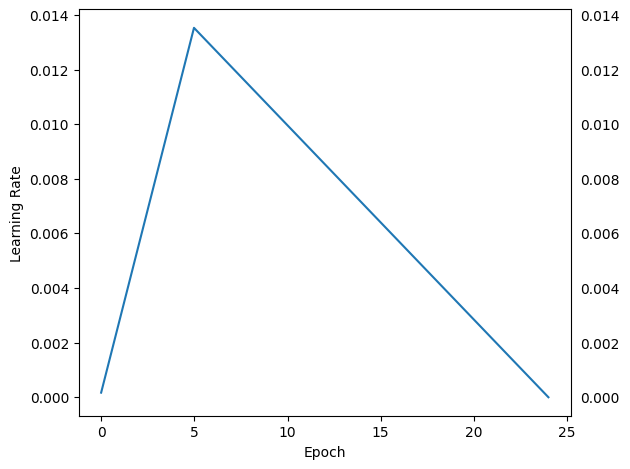

In [8]:
show_lr_history(trainer, EPOCHS)

In [9]:
print(f"Max LR = {max(trainer.lr_history)}")
print(f"Min LR = {min(trainer.lr_history)}")

Max LR = 0.013530477745798068
Min LR = -5.912862374732666e-06


# Get misclassified images from Tester


In [10]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

# Show misclassified images


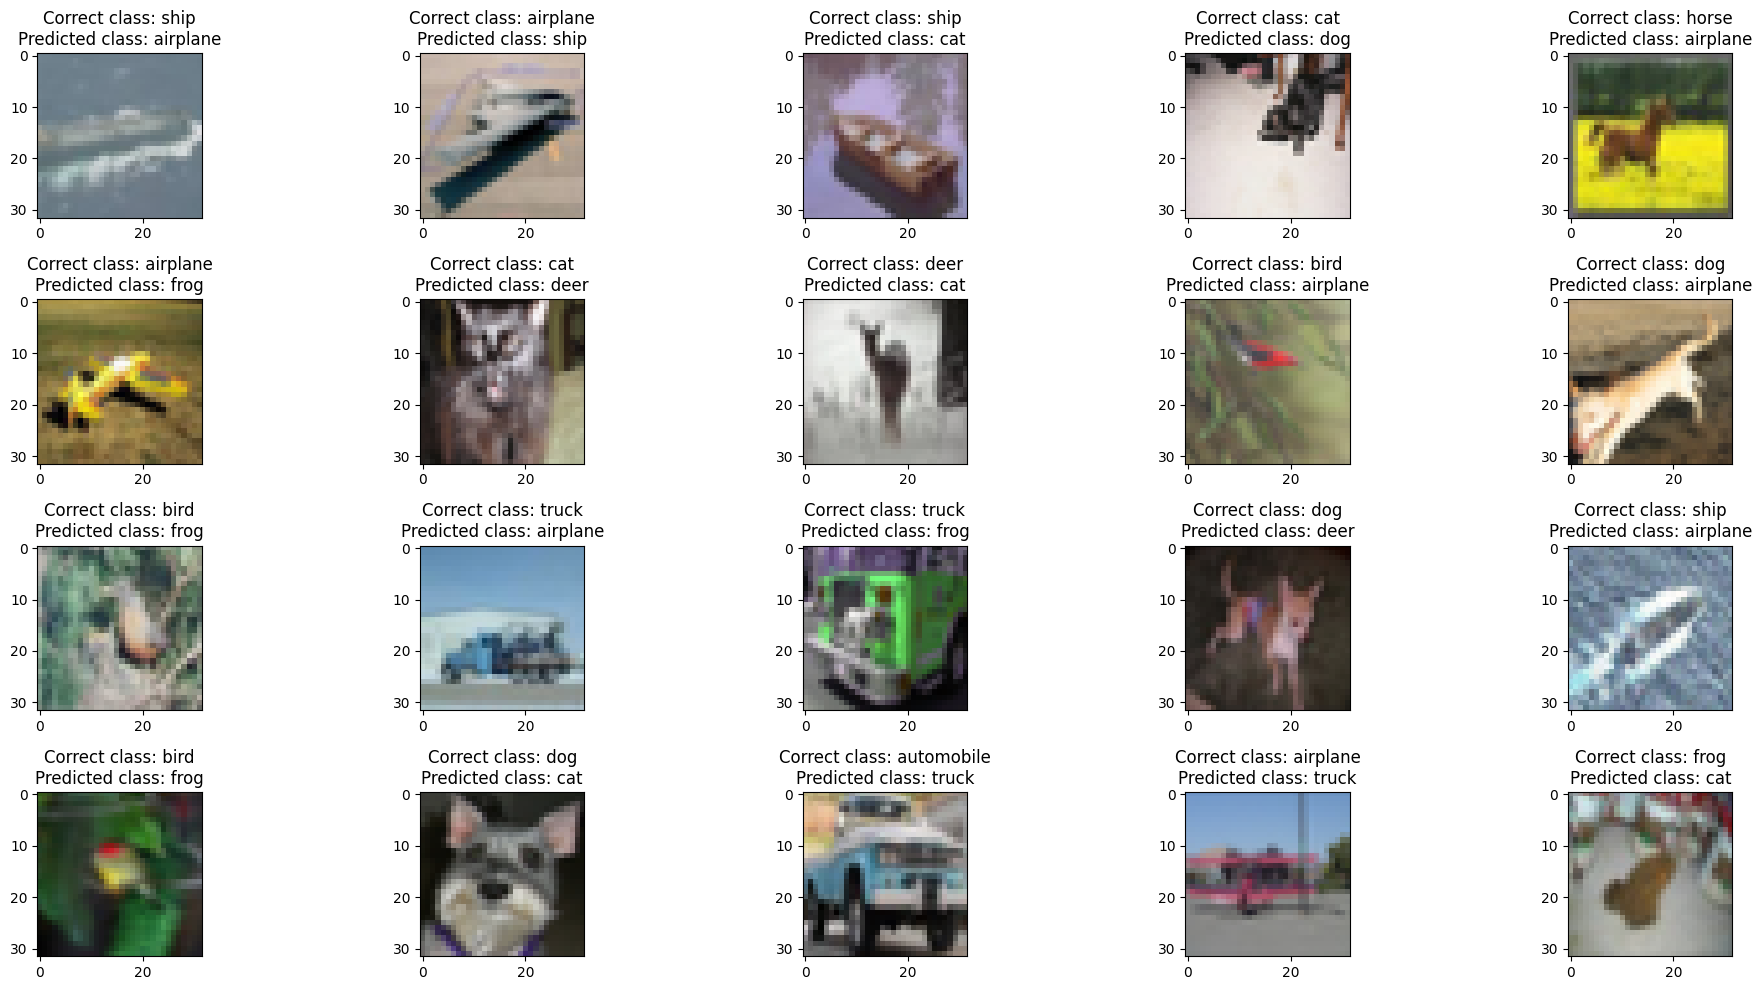

In [11]:
show_misclassified_images(
    misclassified_images[:20], predictions[:20], labels[:20], cifar10.classes
)

# Grad-CAM of misclassified images for correct labels

_This is what model sees for correct labels but it was not enough for correct prediction._


- ## Layer 2


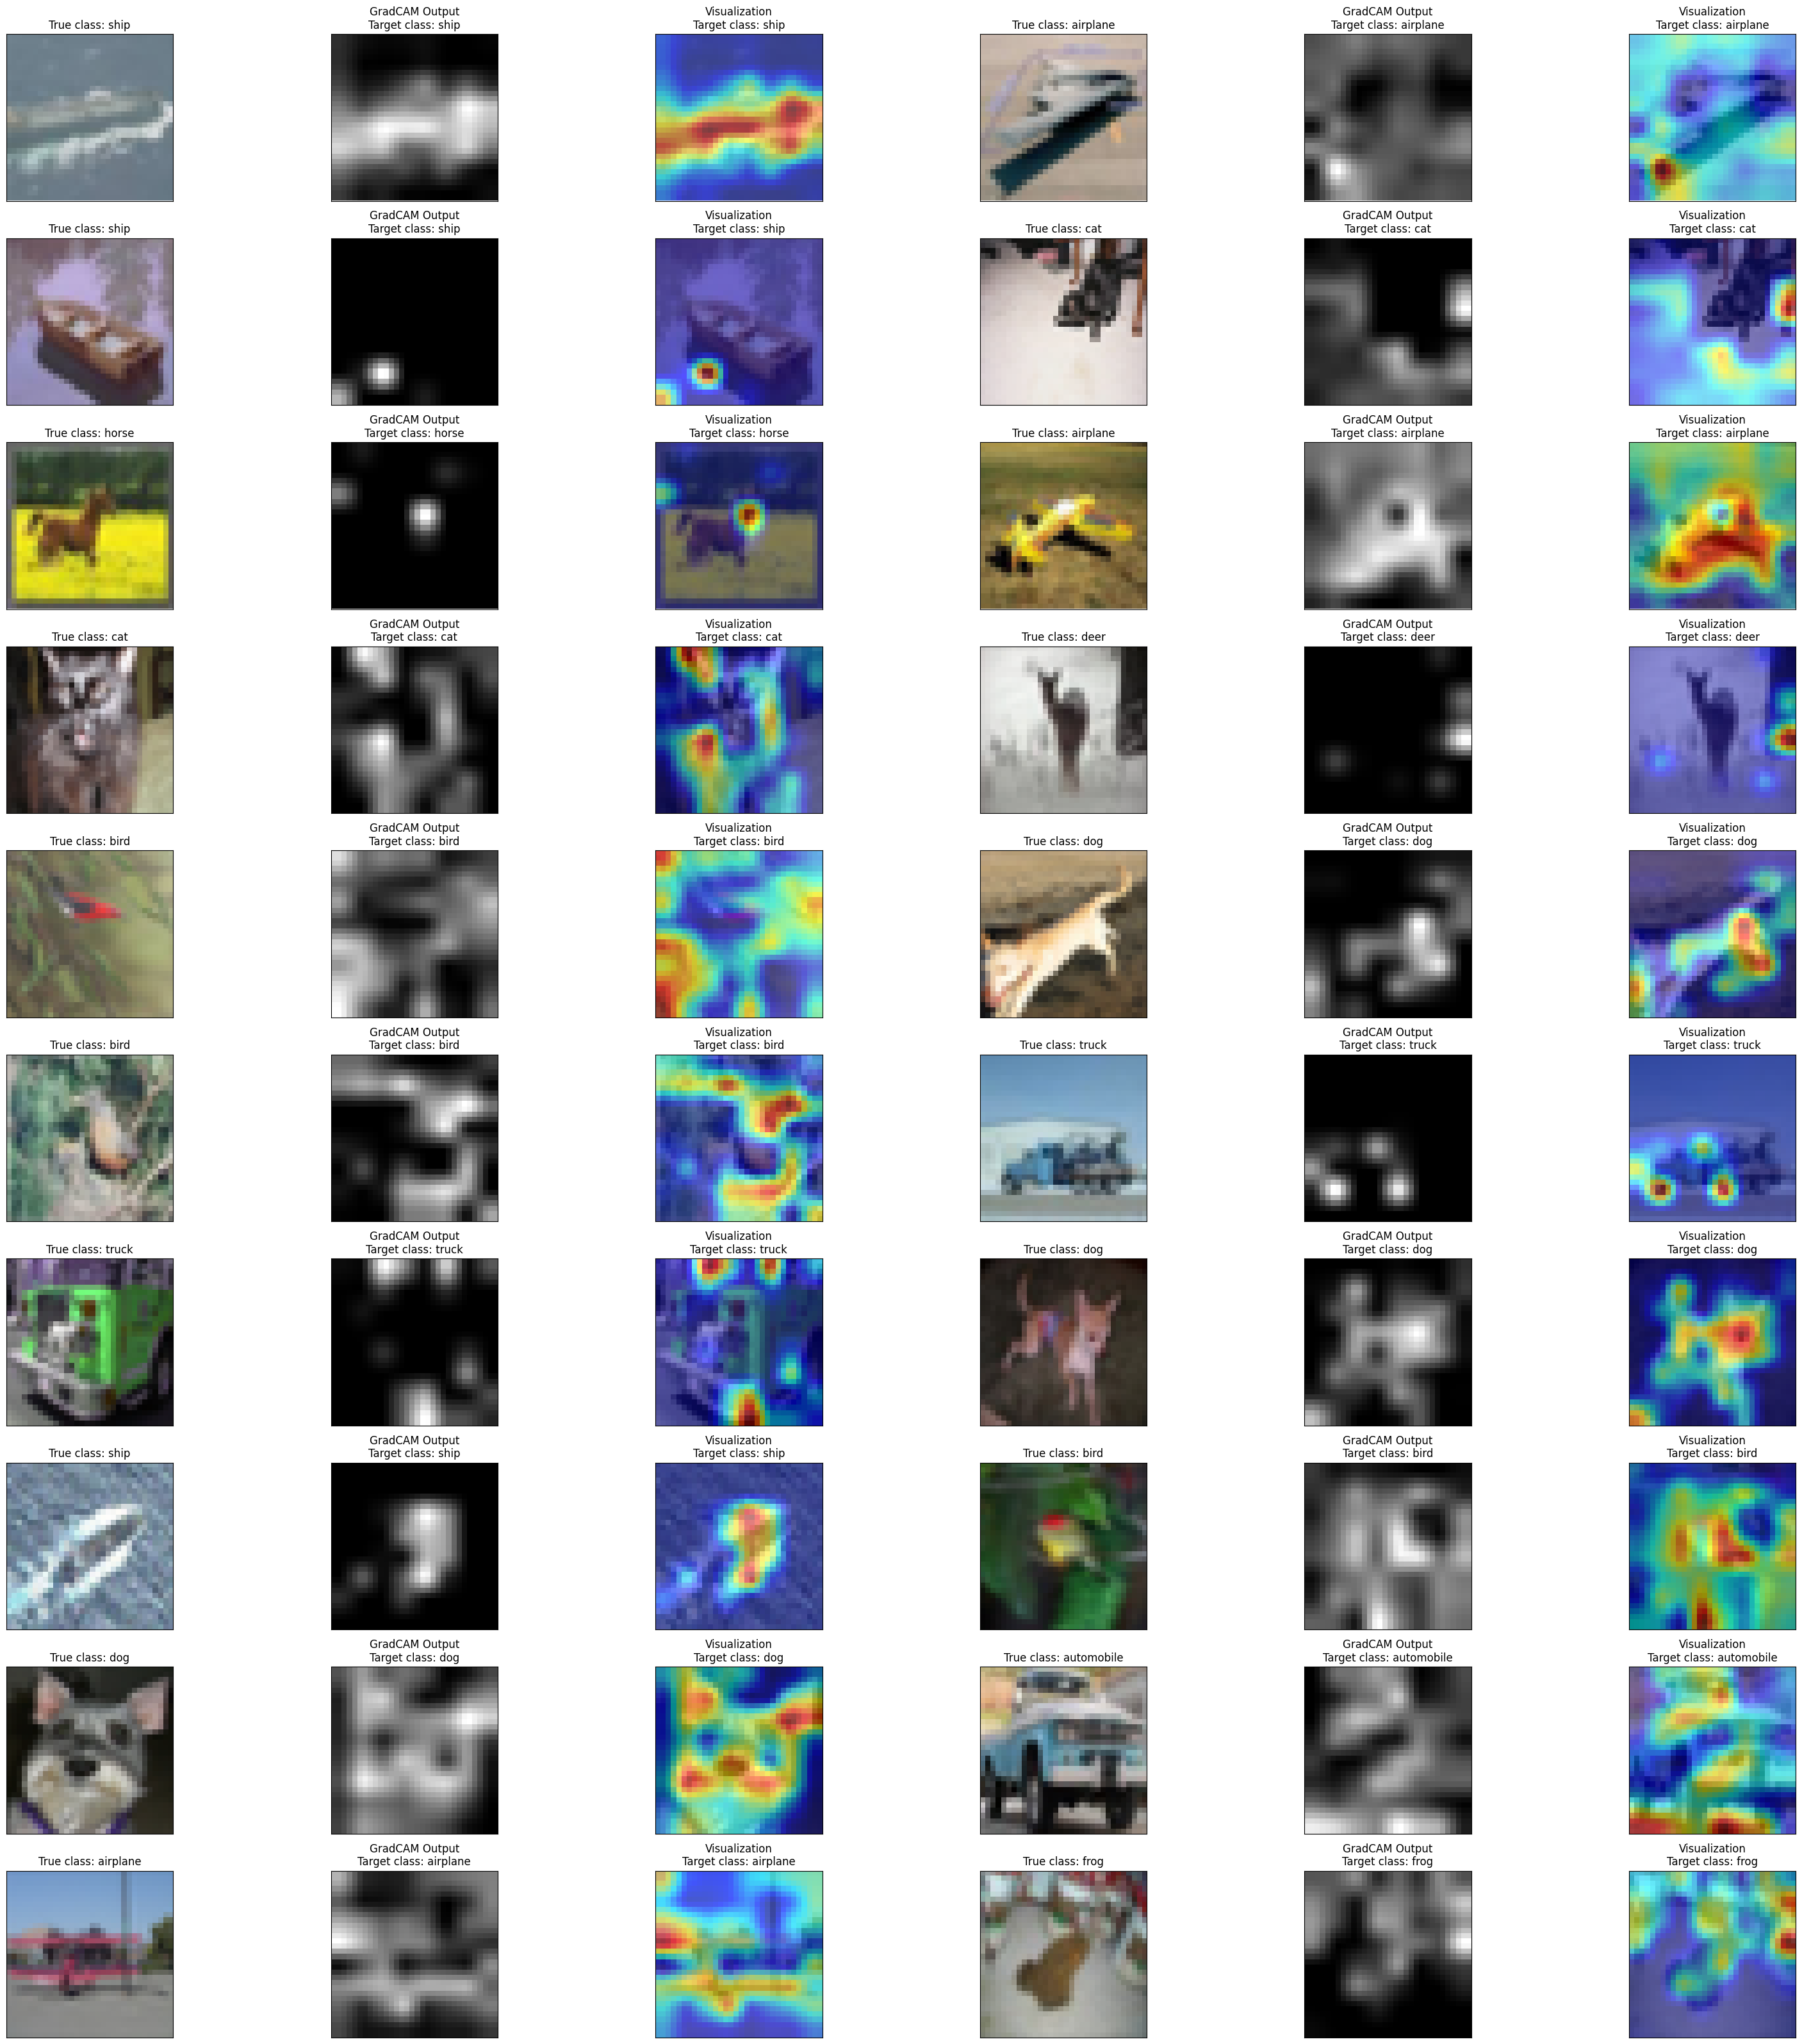

In [12]:
show_grad_cam(
    model,
    device,
    misclassified_images[:20],
    labels[:20],
    labels[:20],
    "layer_2",
    cifar10.classes,
)

- ## Layer 3


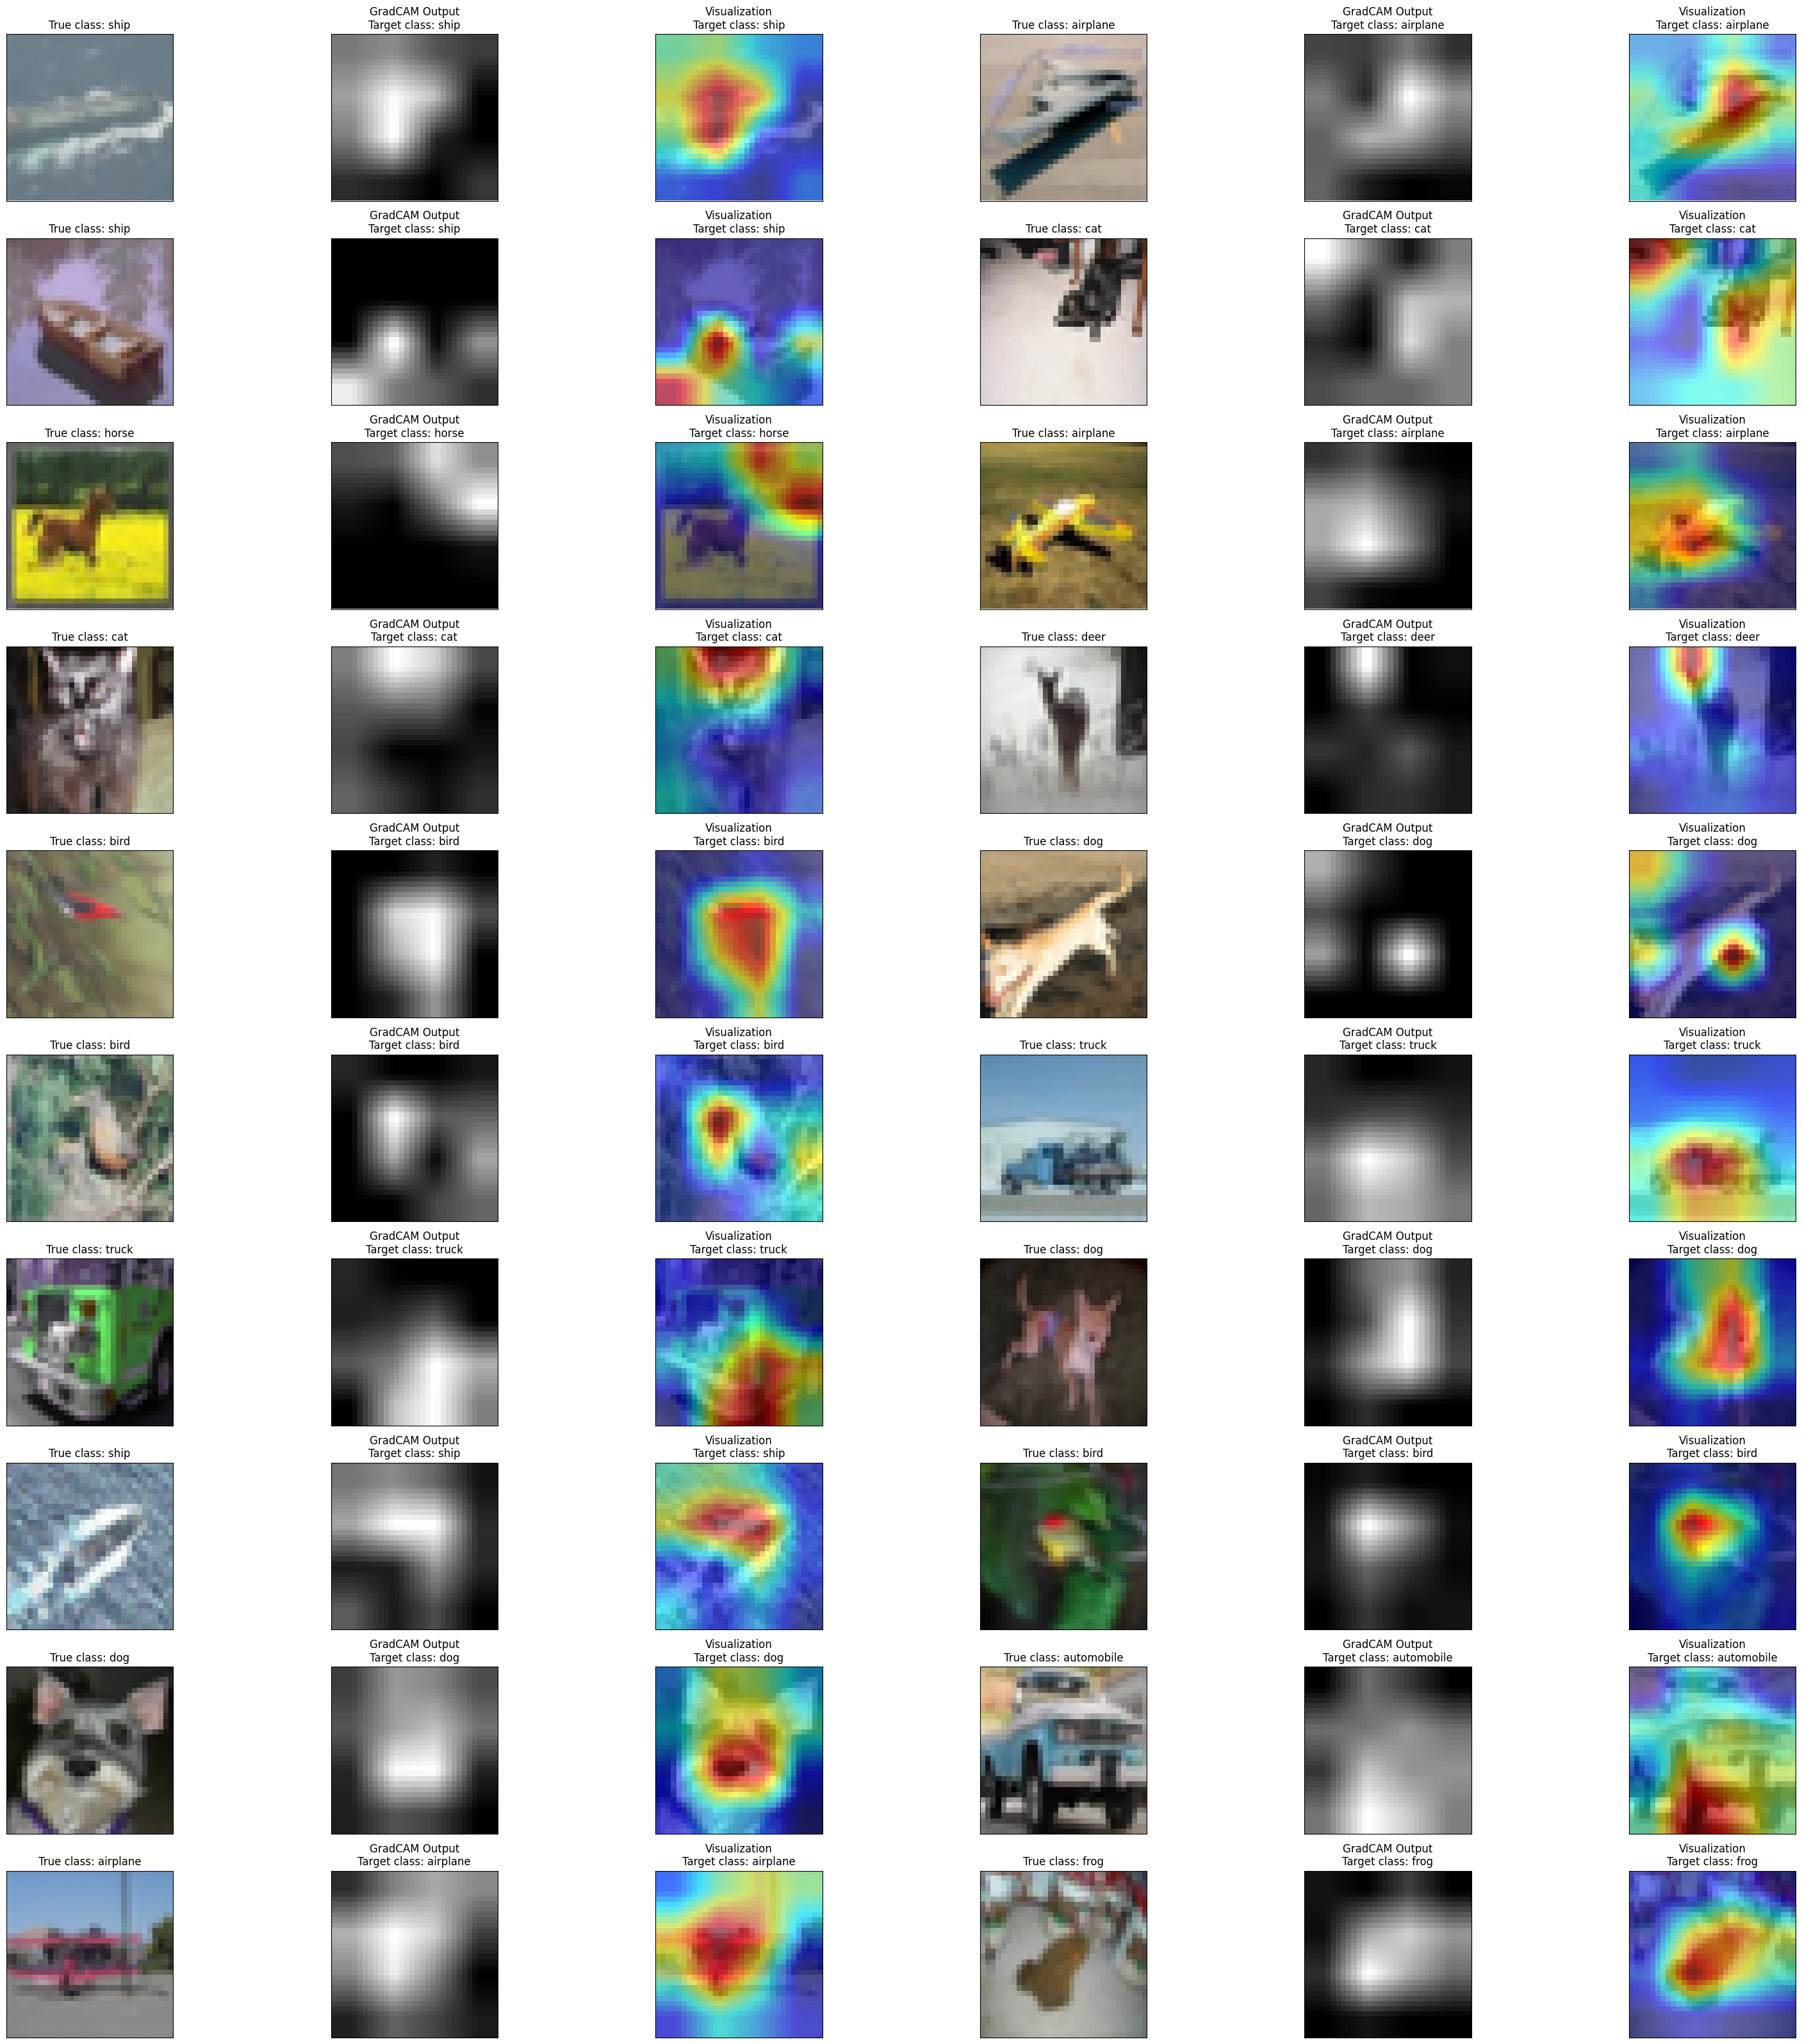

In [13]:
show_grad_cam(
    model,
    device,
    misclassified_images[:20],
    labels[:20],
    labels[:20],
    "layer_3",
    cifar10.classes,
)

# Grad-CAM of misclassified images for predictions

_This is what model sees that it based its prediction on._


- ## Layer 2


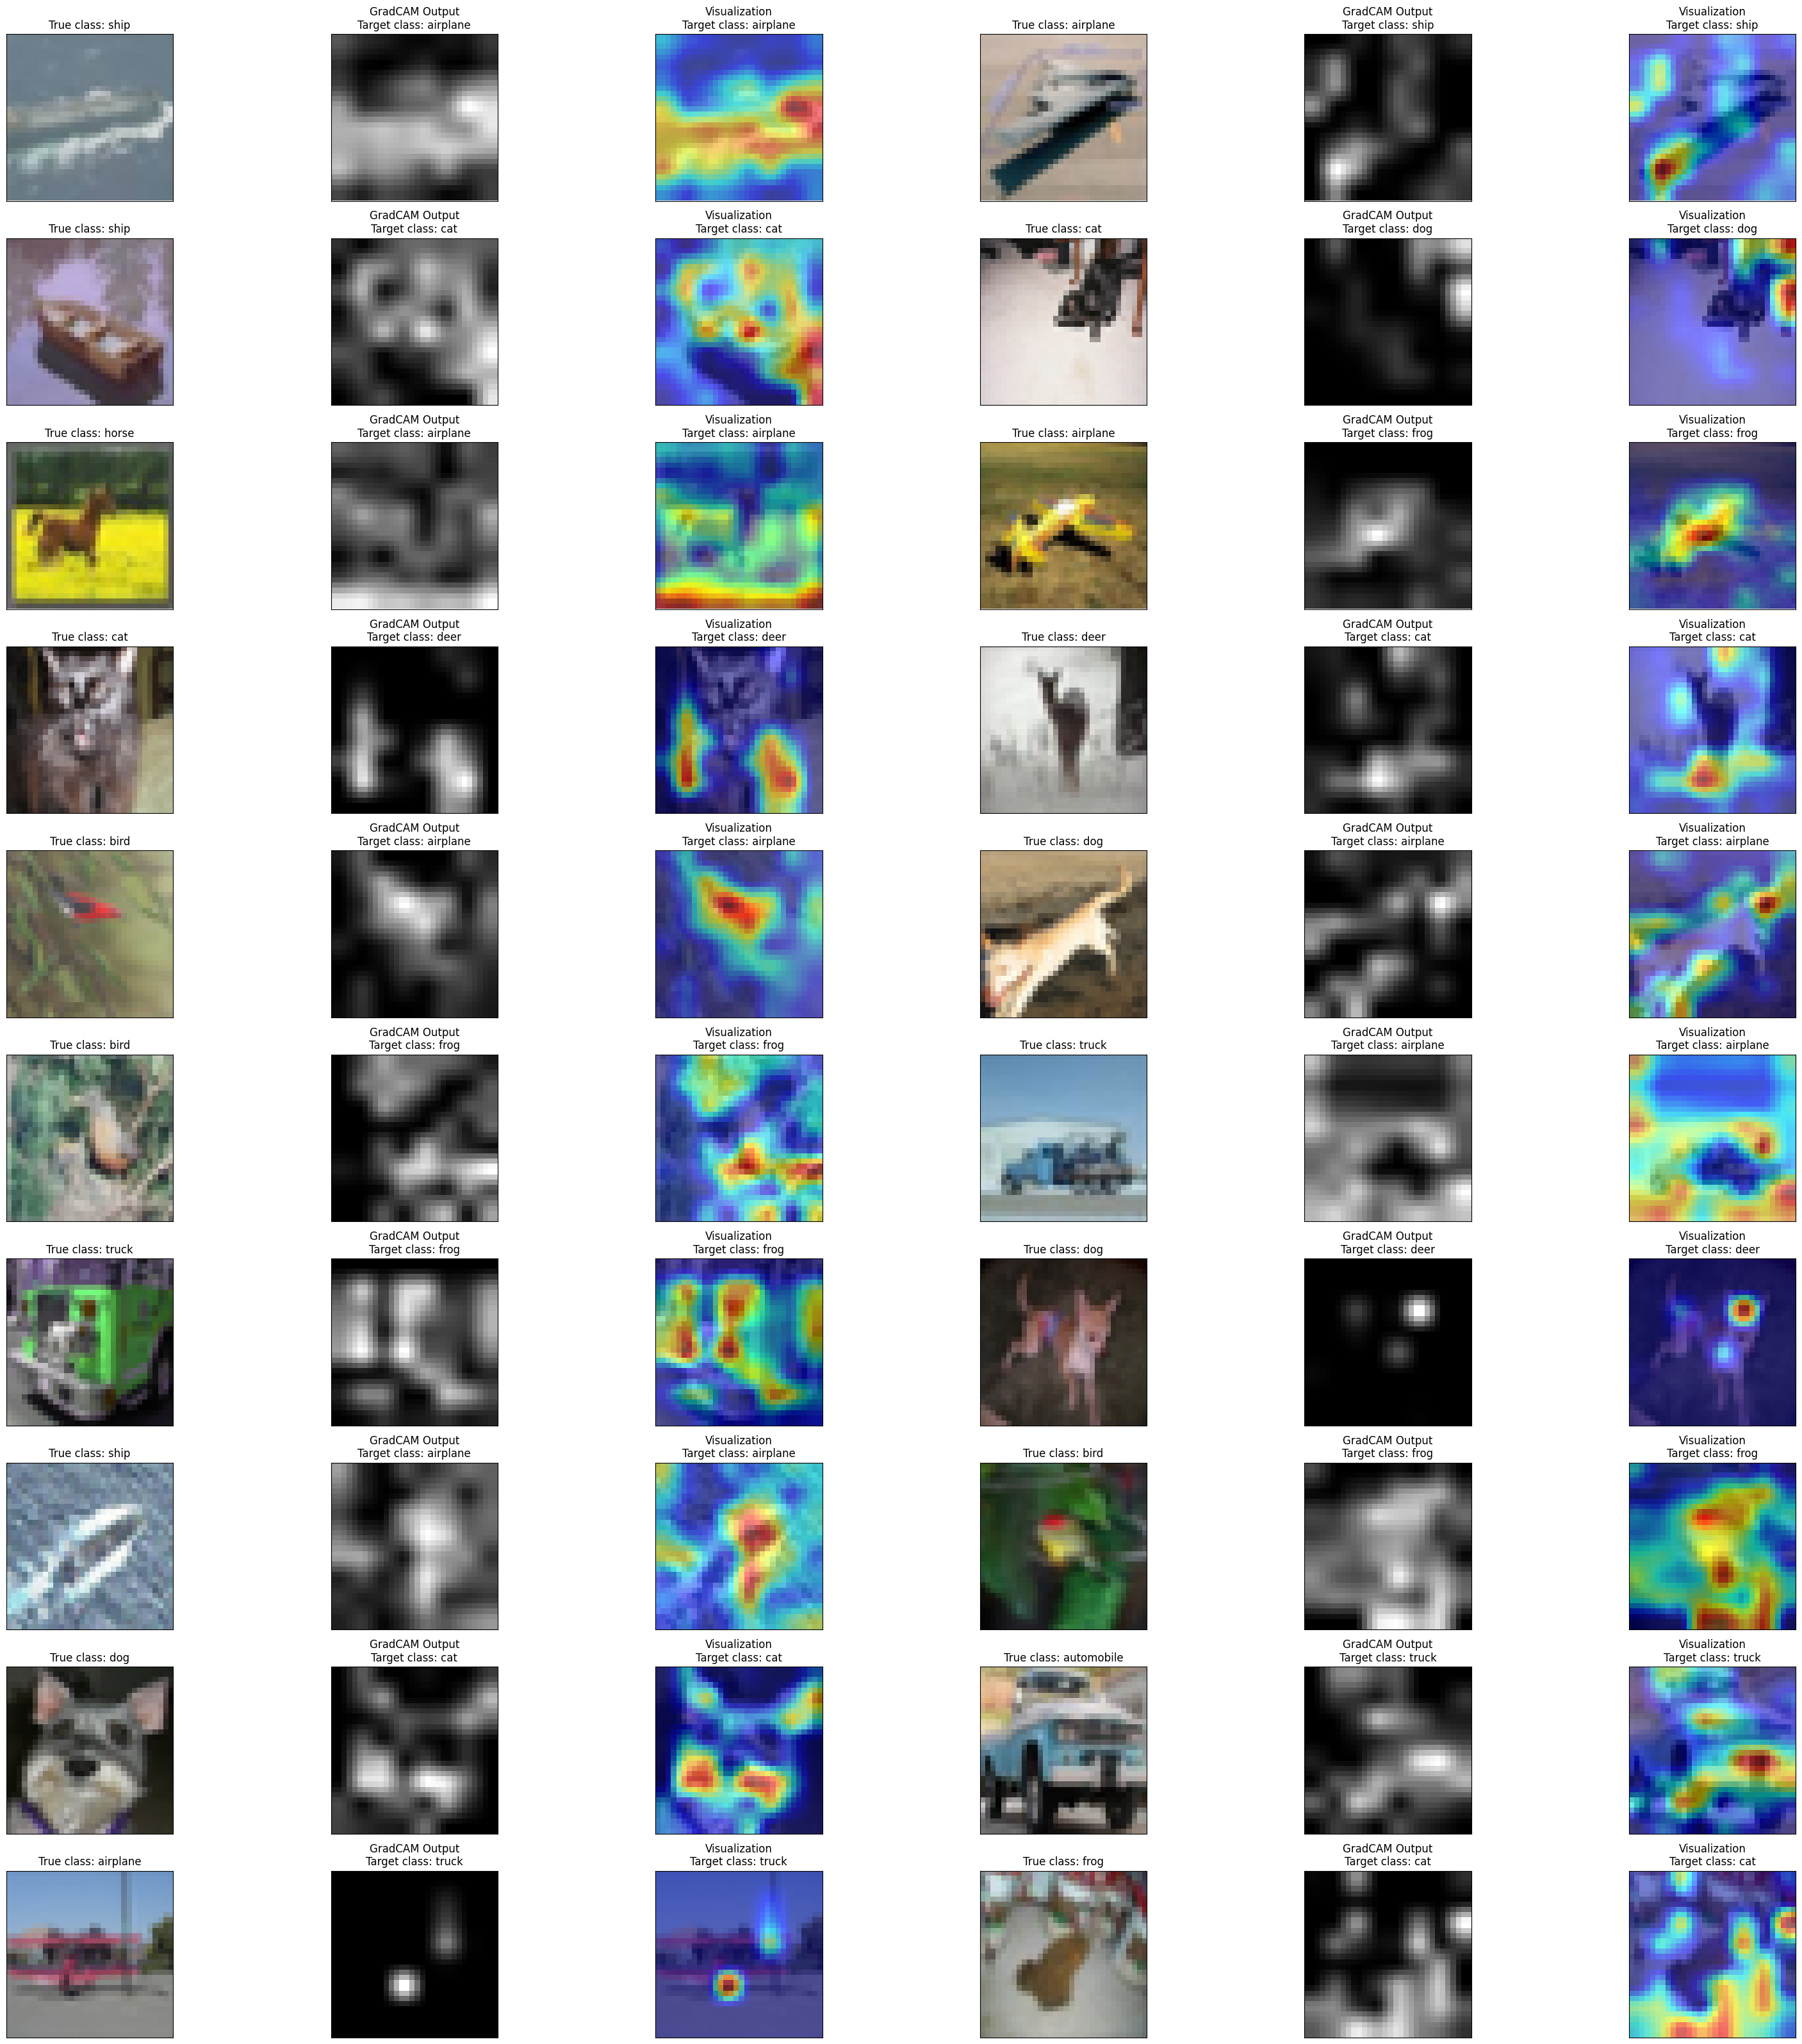

In [14]:
show_grad_cam(
    model,
    device,
    misclassified_images[:20],
    labels[:20],
    predictions[:20],
    "layer_2",
    cifar10.classes,
)

- ## Layer 3


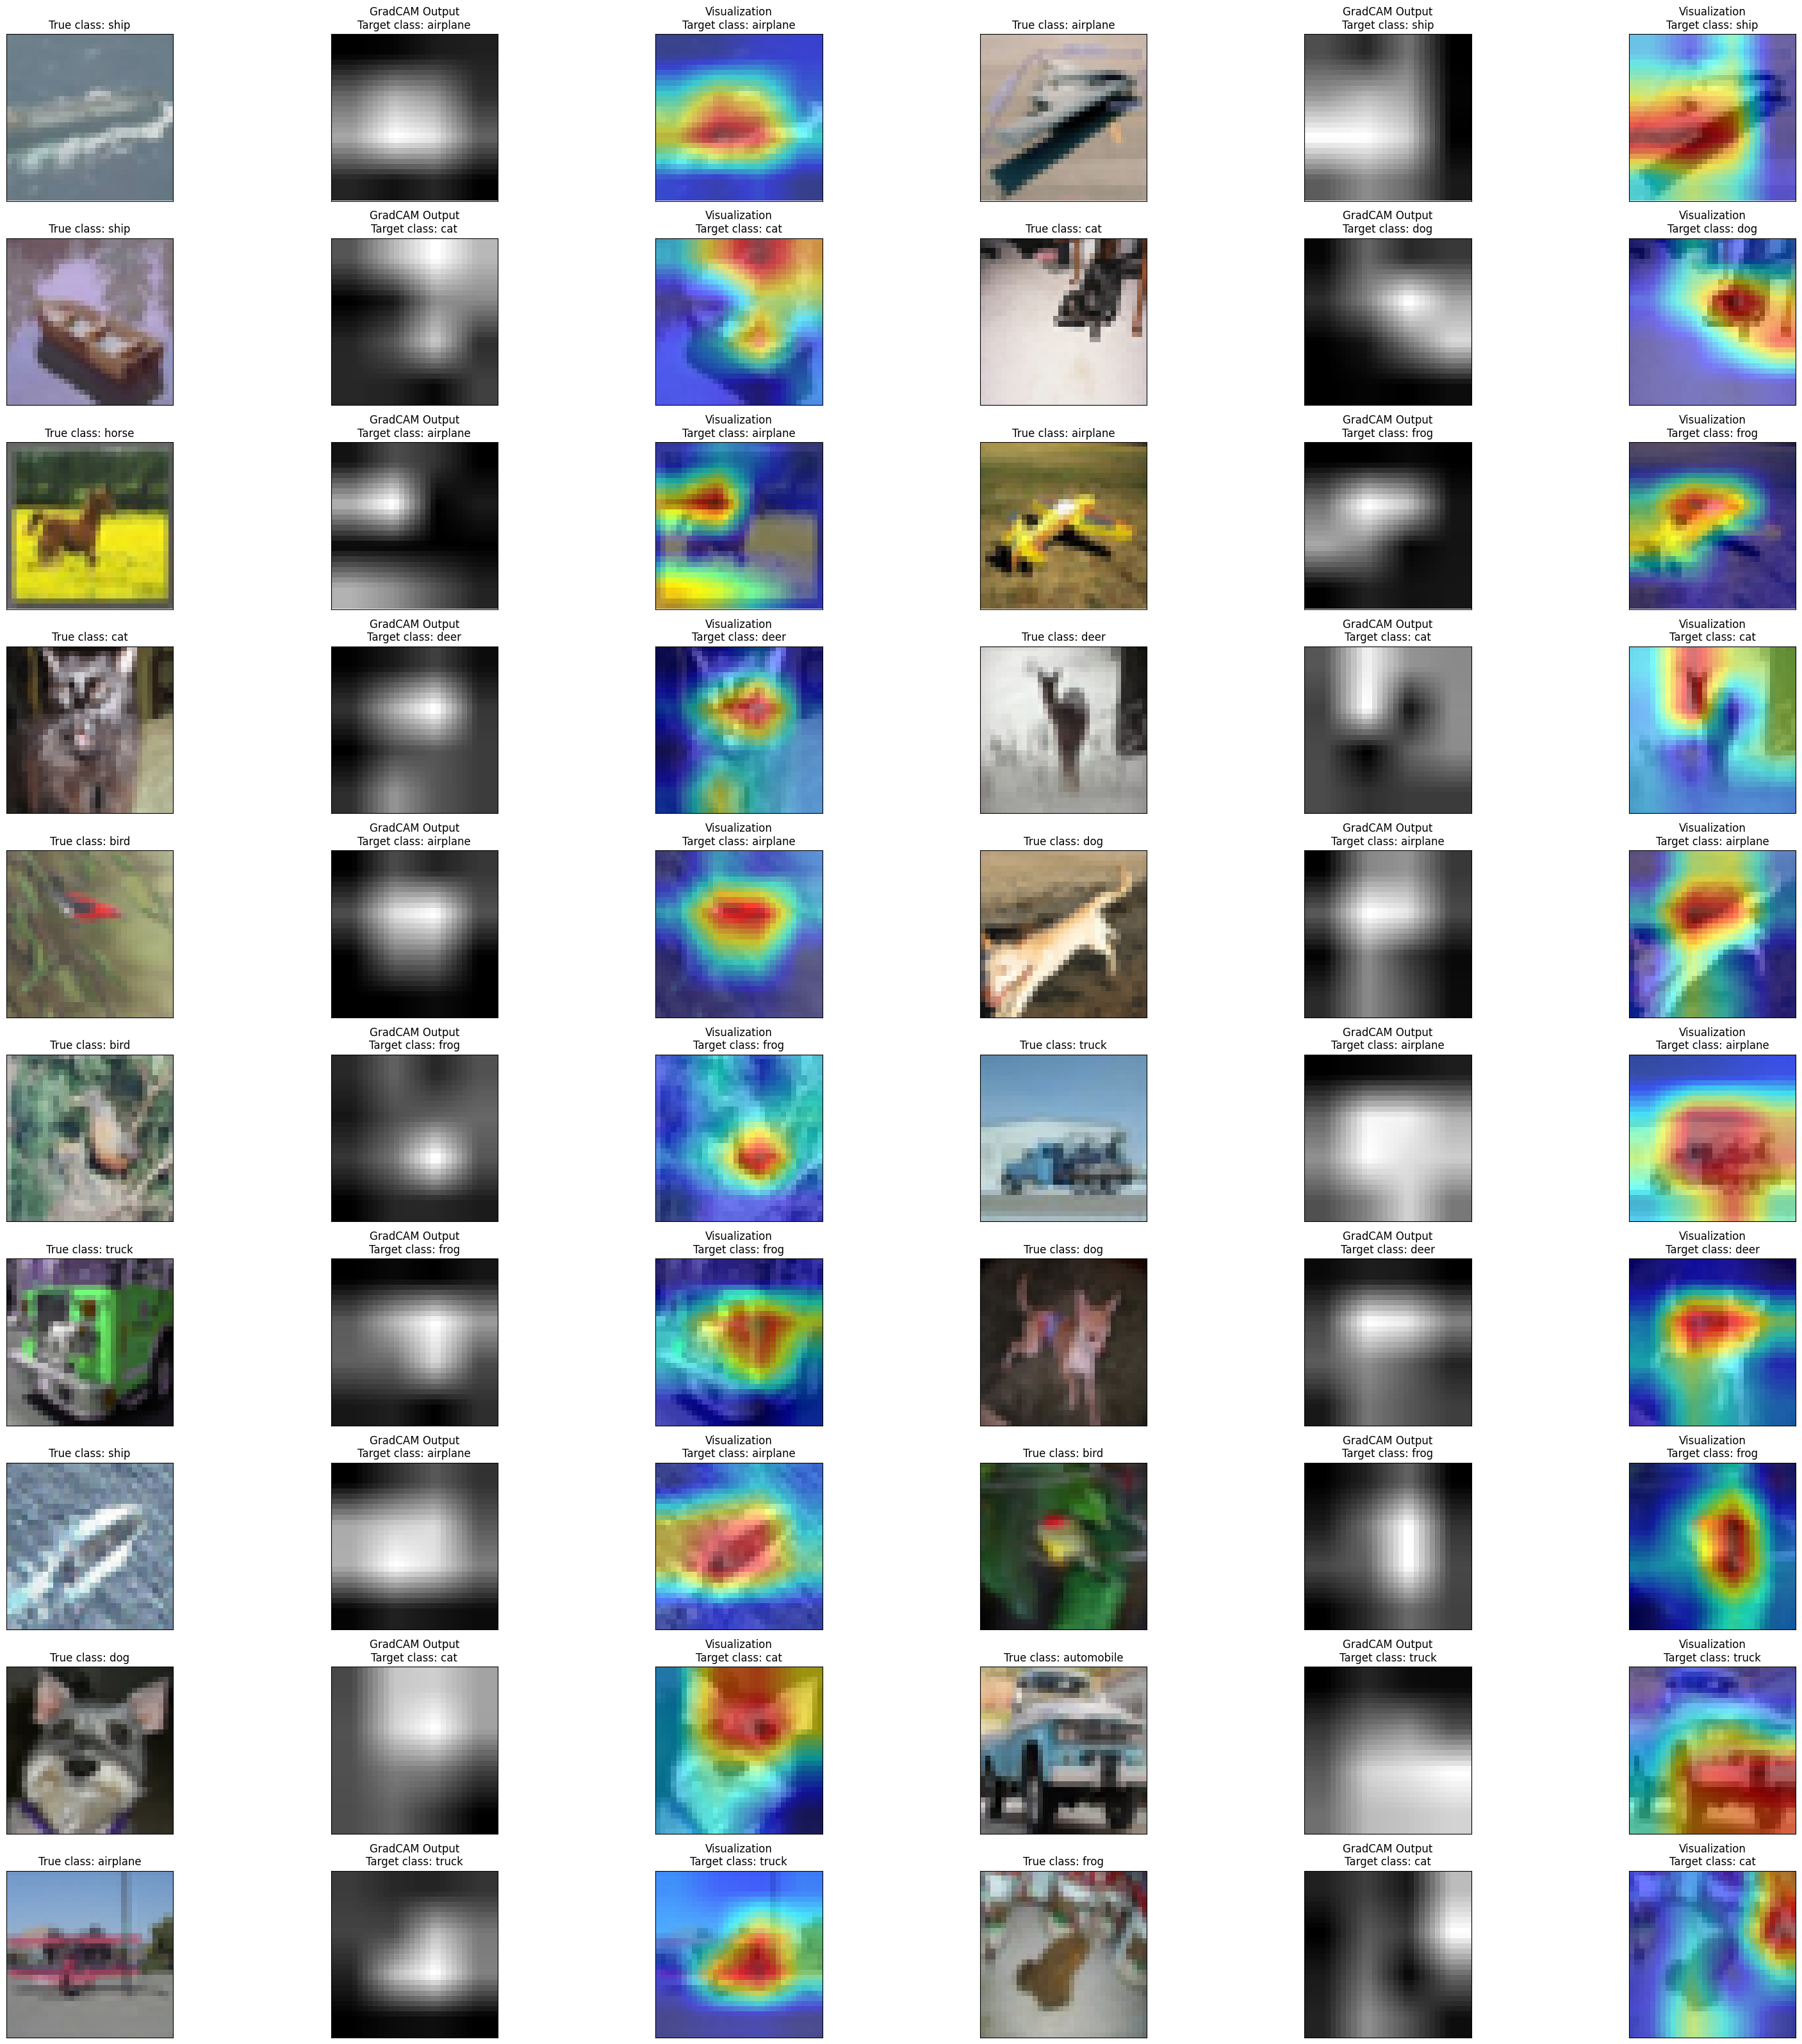

In [15]:
show_grad_cam(
    model,
    device,
    misclassified_images[:20],
    labels[:20],
    predictions[:20],
    "layer_3",
    cifar10.classes,
)

# Loss and Accuracy Graphs for Training and Testing


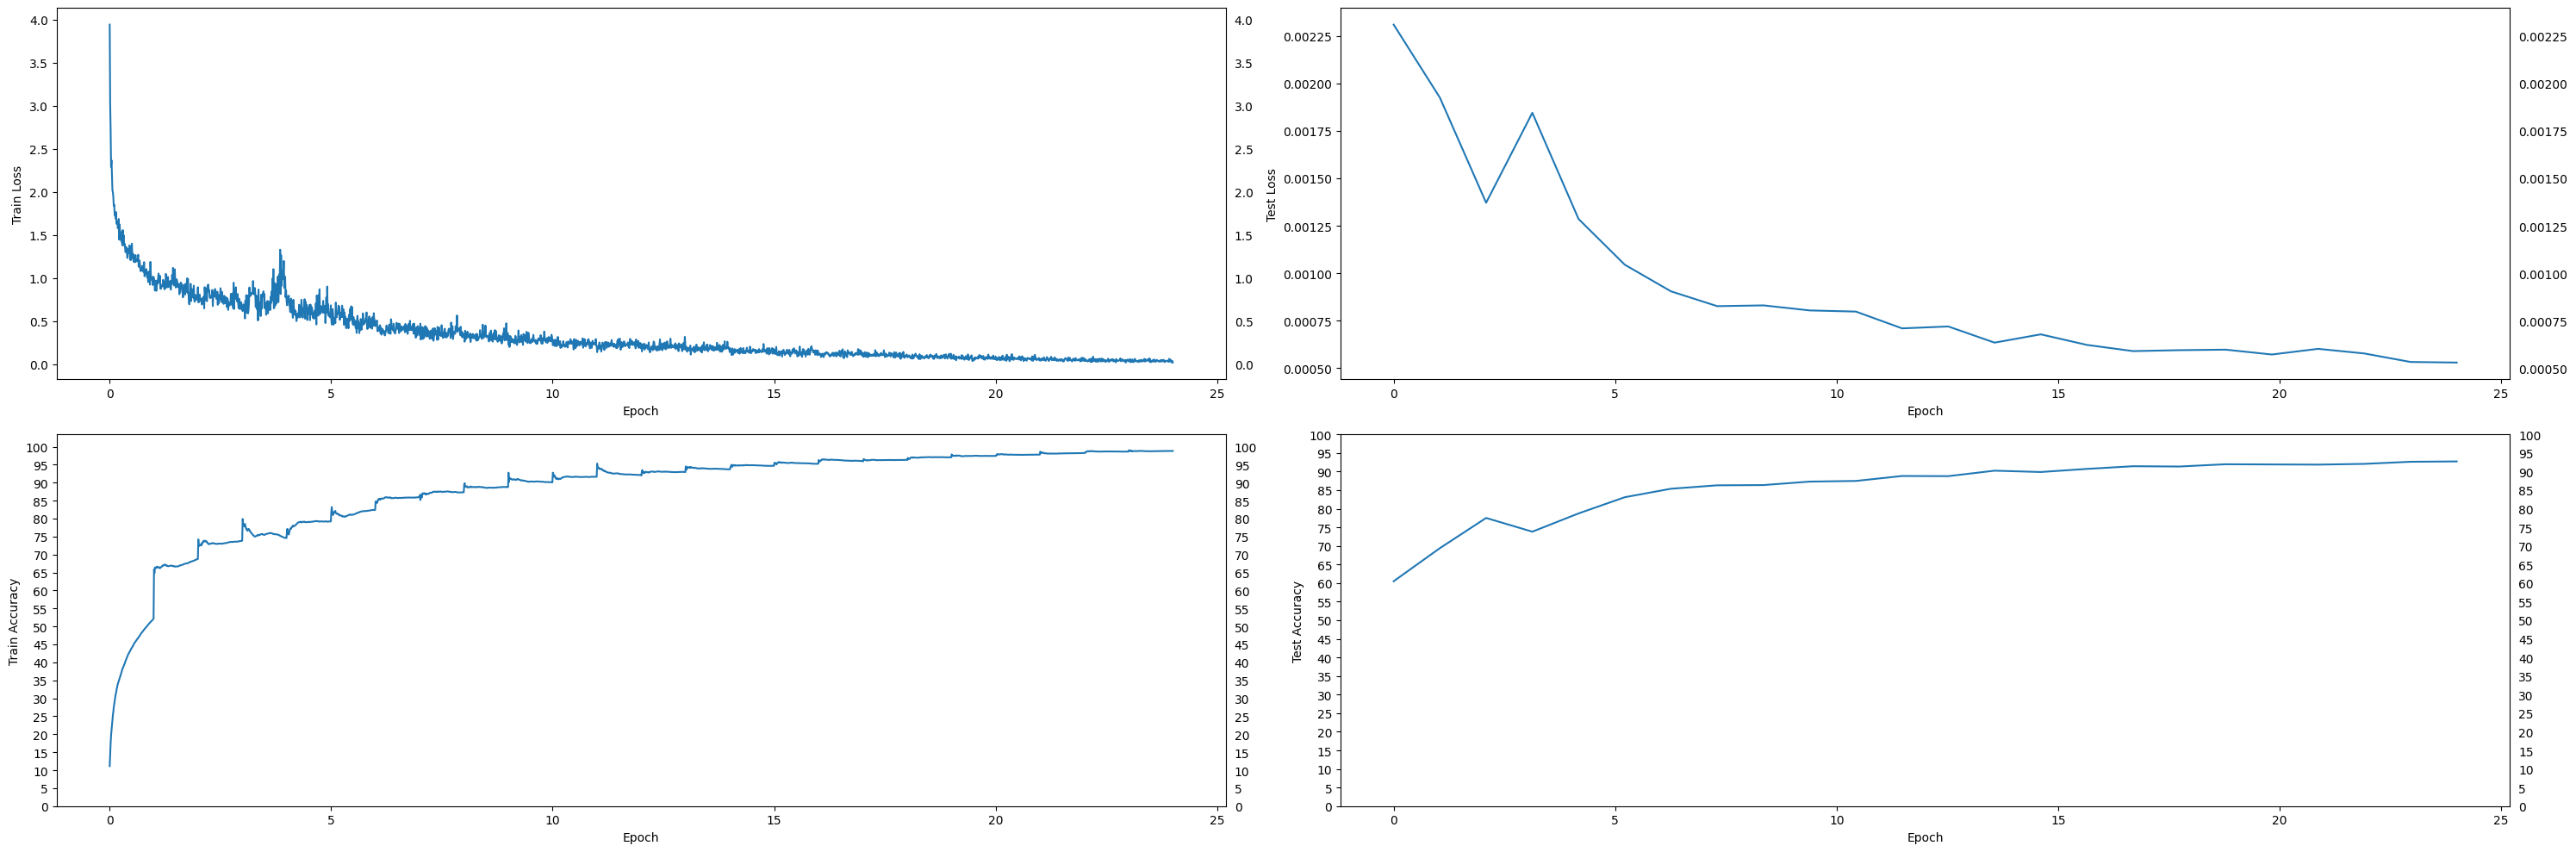

In [16]:
show_losses_and_accuracies(trainer, tester, EPOCHS)